In [5]:
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())
os.chdir('/home/vco/Projects/pm4py-dcr') # working directory should be pm4py-dcr (the one behind notebooks)
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/vco/Projects/pm4py-dcr
/home/vco/Projects/pm4py-dcr


In [101]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys                                             # Module to see files and folders in directories
import scipy
import pm4py

from fitter import Fitter, get_common_distributions, get_distributions
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.objects.log.util import dataframe_utils
from itertools import chain, combinations
from scipy.stats import expon, lognorm, norm, poisson, uniform
import numpy as np
import matplotlib as mpl                # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit,cost                             # The actual fitting tool, better than scipy's
from scipy import stats
import pandas as pd
import pickle

from pm4py.util.external_functions import Chi2Regression
from pm4py.util.external_functions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

r = np.random                         # Random generator
r.seed(1)                            # Set a random seed (but a fixed one - more on that later.)

save_plots = False

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

from IPython.display import clear_output
from distfit import distfit

In [72]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

#### Test data

## Pseudocode

Function(log,array(Rule,Event1,Event2)):
    result = array()
    for each trace in Log do:
        for each (Rule, Event1, Event2) in T_tuple do:
            scoped_log <- create a subset of traces from log that contain both event1 and event2
            only_event1_event2_log <- from each trace create a subset of scoped_log that only has data related to event1 and event2
            sort(only_event1_event2) <- sort by case:concept:name and time:timestamp
            if Rule is DELAY then
                delta = timestep_event2 - timestep_first_preceeding_event1
            else Rule is DEADLINE
                delta = MAX(|timestep_between_consecutve_event1| or (timestep_event2-timestep_first_preceeding_event1))
            result.append(timing_data)
     return result

In [9]:
def get_log_with_pair(event_log,e1,e2):
    first_e1 = event_log[event_log['concept:name']==e1].groupby('case:concept:name')[['case:concept:name','time:timestamp']].first().reset_index(drop=True)
    subset_is_in = first_e1.merge(event_log,on='case:concept:name',how='inner',suffixes=('_e1', ''))
    cids = subset_is_in[((subset_is_in['time:timestamp_e1']<subset_is_in['time:timestamp']) & (subset_is_in['concept:name']==e2))]['case:concept:name'].unique()
    return event_log[event_log['case:concept:name'].isin(cids)].copy(deep=True)

def get_max_for_response(temp_df):
    '''
    This method is a way to find the max response (deadline).
    Within a trace it keeps track of the max delta between either (e1,e1) or (e1,e2) pairs.
    When it reaches a (e1,e2) pair it updates the delta on that row with the max delta found in preceeding pairs.
    This means that it will either take the current row delta because this is the only occurence of (e1,e2)
    or it will take a delta from a previous pair of (e1,e1) and assign it to that pair (e1,e2)
    :param temp_df: this is a dataframe with only the event pairs (e1 and e2) where at least 1 e1 preceeds an e2 for all traces
    :return:
    '''
    cids = temp_df['case:concept:name'].unique()
    for cid in cids:
        max_days = 0
        for index,row in temp_df[temp_df['case:concept:name']==cid].iterrows():
            max_days = max(max_days,row['delta'])
            if row['concept:name']!=row['concept:name:to']:
                temp_df.loc[index,'delta'] = max_days
                max_days = 0
    return temp_df

def get_delta_between_events(filtered_df, event_pair, rule):

    filtered_df['time:timestamp'] = pd.to_datetime(filtered_df['time:timestamp'], utc=True)
    filtered_df = filtered_df[(filtered_df['concept:name']==event_pair[1]) |
                               (filtered_df['concept:name']==event_pair[0])].sort_values(['case:concept:name','time:timestamp'])
    temp_df = pd.concat([filtered_df, filtered_df.groupby('case:concept:name').shift(-1)
                         .rename({'concept:name':'concept:name:to','time:timestamp':'time:timestamp:to'},axis=1)],axis=1)

    temp_df['delta'] = (temp_df['time:timestamp:to'] - temp_df['time:timestamp']).dt.days

    if rule=='RESPONSE':
        temp_df = get_max_for_response(temp_df)
    temp_df = temp_df[(temp_df['concept:name']==event_pair[0]) & (temp_df['concept:name:to']==event_pair[1])]
    data = temp_df['delta'].values
    return data

def create_timing_input_dict(model):
    with open(model) as file:
        lines = file.readlines()
        lines = [line.strip() for line in lines]

    events = []
    conditions = []
    responses = []
    #includes = []
    #excludes = []
    for line in lines:
        temp = line.split(',')
        if temp[0] == 'EVENT':
            events.append(temp[1])
        elif temp[0] == 'CONDITION':
            conditions.append(temp[1:])
        elif temp[0] == 'RESPONSE':
            responses.append(temp[1:])

    timing_input_dict = {'CONDITION' : conditions,
                         'RESPONSE': responses}
    return timing_input_dict

def get_timings(log,timing_input_dict):
    if isinstance(log,pd.DataFrame):
        event_log = log
    else:
        event_log = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
    res = {}

    for rule, event_pairs in timing_input_dict.items():
        #print(rule)
        for event_pair in event_pairs:
            filtered_df = get_log_with_pair(event_log,event_pair[0],event_pair[1]) #= pm4py.filter_between(log,event_pair[0],event_pair[1])
            data = get_delta_between_events(filtered_df,event_pair,rule)
            #print(event_pair)
            res[(rule,event_pair[0],event_pair[1])] = data

    return res

In [10]:
cids = [1,1,1,1,1,1,
        2,2,2,2,2,
        3,3,3,3,3,3,3,3,3,3,
        4,4,4,4,4,4,4,4,4,4,4,4,4]
events = ['A','B','C','D','E','F',
          'A', 'B', 'E', 'F' ,'C',
          'A', 'B', 'F', 'C', 'B', 'C', 'B', 'E', 'F', 'C',
          'B','B','B','Z','B','C','B','A','C','Z','C','C','B']
timestamps = [pd.to_datetime('2021-10-01'),pd.to_datetime('2021-10-02'),pd.to_datetime('2021-10-03'),
                      pd.to_datetime('2021-10-04'),pd.to_datetime('2021-10-05'),pd.to_datetime('2021-10-06'),
                     pd.to_datetime('2021-10-01'),pd.to_datetime('2021-10-02'),pd.to_datetime('2021-10-03'),
                      pd.to_datetime('2021-10-04'),pd.to_datetime('2021-10-05'),
                     pd.to_datetime('2021-10-01'),pd.to_datetime('2021-10-02'),pd.to_datetime('2021-10-03'),
                      pd.to_datetime('2021-10-04'),pd.to_datetime('2021-10-05'),pd.to_datetime('2021-10-06'),pd.to_datetime('2021-10-07'),
                      pd.to_datetime('2021-10-08'),pd.to_datetime('2021-10-09'),pd.to_datetime('2021-10-10'),
                     pd.to_datetime('2020-01-01'),pd.to_datetime('2021-02-02'),pd.to_datetime('2021-02-03'),
                      pd.to_datetime('2021-02-04'),pd.to_datetime('2021-02-05'),pd.to_datetime('2021-10-06'),
                      pd.to_datetime('2021-10-07'),pd.to_datetime('2021-10-08'),pd.to_datetime('2021-10-09'),
                      pd.to_datetime('2021-10-10'),pd.to_datetime('2021-10-11'),pd.to_datetime('2025-10-11'),pd.to_datetime('2040-10-11')]
test_log_dict = {
    'case:concept:name':cids,
    'concept:name':events,
    'time:timestamp':timestamps
}

test_tid = {
    'CONDITION': [['B','C']],
    'RESPONSE': [['B','C']]
}

test_log_df = pd.DataFrame(test_log_dict)
test_event_log = log_converter.apply(test_log_df)

In [11]:
get_timings(test_log_df,test_tid)

{('CONDITION', 'B', 'C'): array([  1.,   3.,   2.,   1.,   3., 243.,   2.]),
 ('RESPONSE', 'B', 'C'): array([  1.,   3.,   2.,   1.,   3., 398.,   2.])}

In [12]:


#print(get_timings(test_log_df[test_log_df['case:concept:name']==4],test_tid))
res = {}
for i in range(1,5):
    k = get_timings(test_log_df[test_log_df['case:concept:name']==i],test_tid)
    for i,v in k.items():
        if i in res:
            res[i] = np.append(res[i],v)
        else:
            res[i] = v

In [13]:
res

{('CONDITION', 'B', 'C'): array([  1.,   3.,   2.,   1.,   3., 243.,   2.]),
 ('RESPONSE', 'B', 'C'): array([  1.,   3.,   2.,   1.,   3., 398.,   2.])}

# Util methods

In [14]:
def get_timings(log,timing_input_dict):
        if isinstance(log,pd.DataFrame):
            event_log = log
        else:
            event_log = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
        res = {}

        for rule, event_pairs in timing_input_dict.items():
            #print(rule)
            for event_pair in event_pairs:
                filtered_df = pm4py.filter_between(log,event_pair[0],event_pair[1])
                
                filtered_df['time:timestamp'] = pd.to_datetime(filtered_df['time:timestamp'], utc=True)
                filtered_df = filtered_df[(filtered_df['concept:name']==event_pair[1]) |
                                   (filtered_df['concept:name']==event_pair[0])].sort_values(['case:concept:name','time:timestamp'])
                temp_df = pd.concat([filtered_df, filtered_df.groupby('case:concept:name').shift(-1)
                             .rename({'concept:name':'concept:name:to','time:timestamp':'time:timestamp:to'},axis=1)],axis=1)

                temp_df['delta'] = (temp_df['time:timestamp:to'] - temp_df['time:timestamp']).dt.days

                if rule=='RESPONSE':
                    cid=None
                    max_days = 0
                    for index,row in temp_df.iterrows():
                        if cid == row['case:concept:name']:
                            max_days = max(max_days,row['delta'])
                            if row['concept:name']!=row['concept:name:to']:
                                #print(max_days,' row: ',row)
                                temp_df.loc[index,'delta'] = max_days
                                max_days = 0
                        else:
                            max_days = 0
                        cid = row['case:concept:name']
                        
                temp_df = temp_df[(temp_df['concept:name']==event_pair[0]) & (temp_df['concept:name:to']==event_pair[1])]
                data = temp_df['delta'].values
                #print(event_pair)
                res[(rule,event_pair[0],event_pair[1])] = data

        return res

In [15]:
def freedman_diaconis_rule(data):
    """rule to find the bin width and number of bins from data"""
    if (stats.iqr(data)>0):
        bin_width = 2*stats.iqr(data) / len(data)**(1/3)
        Nbins = int(np.ceil((max(data)-min(data))/bin_width))
        return Nbins, bin_width
    else:
        return 100, 0

def uniform_pdf(x,a,b):
    if a<=x and x<=b:
        return 1/(b-a)
    else:
        return 0
    
def exp_pdf(x, tau):
    """Exponential with lifetime tau"""
    return 1.0 / tau * np.exp(-x/tau)

def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

def N_gauss_pdf(x, N, mu, sigma) :
    """Gaussian"""
    return N*binwidth*gauss_pdf(x, mu, sigma)

def log_gauss_pdf(x,mu,sigma):
    return 1.0 / np.sqrt(2*np.pi) / (sigma*x) * np.exp(-0.5 * (np.log(x)-mu)**2 / sigma**2)

def N_log_gauss_pdf(x,N,mu,sigma):
    return N*binwidth*log_gauss_pdf(x,mu,sigma)

def double_gaussian(x,N,mu,sigma,N2,mu2,sigma2):
    return N*binwidth*gauss_pdf(x,mu,sigma) + N2*binwidth*gauss_pdf(x,mu2,sigma2)

def triple_gaussian(x,N,mu,sigma,N2,mu2,sigma2,N3,mu3,sigma3):
    return N*binwidth*gauss_pdf(x,mu,sigma) + N2*binwidth*gauss_pdf(x,mu2,sigma2) + N3*binwidth*gauss_pdf(x,mu3,sigma3)

def triple_gauss_gauss_log(x,N,mu,sigma,N2,mu2,sigma2,N3,mu3,sigma3):
    return N*binwidth*gauss_pdf(x,mu,sigma) + N2*binwidth*gauss_pdf(x,mu2,sigma2) + N3*binwidth*log_gauss_pdf(x,mu3,sigma3)

# def triple_gauss_log_log(x,N,mu,sigma,N2,mu2,sigma2,N3,mu3,sigma3):
#     return N*binwidth*gauss_pdf(x,mu,sigma) + N2*binwidth*log_gauss_pdf(x,mu2,sigma2) + N3*binwidth*log_gauss_pdf(x,mu3,sigma3)

def triple_gauss_log_log(x,N,mu,sigma,N2,mu2,sigma2,N3,mu3,sigma3):
    if x<61:
        return N*binwidth*gauss_pdf(x,mu,sigma)
    else:
        return N2*binwidth*log_gauss_pdf(x,mu2,sigma2) + N3*binwidth*log_gauss_pdf(x,mu3,sigma3)

def double_log_gaussian(x,N,mu,sigma,N2,mu2,sigma2,binwidth):
    return N*binwidth*log_gauss_pdf(x,mu,sigma) + N2*binwidth*log_gauss_pdf(x,mu2,sigma2)

def double_log_gaussian_exp(x,N_exp, tau,N,mu,sigma,N2,mu2,sigma2,binwidth):
    return N_exp*binwidth*exp_pdf(x,tau) + N*binwidth*log_gauss_pdf(x,mu,sigma) + N2*binwidth*log_gauss_pdf(x,mu2,sigma2)

def double_gaussian_exp(x,N_exp, tau,N,mu,sigma,N2,mu2,sigma2):
    return N_exp*binwidth*exp_pdf(x,tau) + N*binwidth*gauss_pdf(x,mu,sigma) + N2*binwidth*gauss_pdf(x,mu2,sigma2)

def gaus_log_gauss_exp(x,N_exp, tau,N,mu,sigma,N2,mu2,sigma2):
    return N_exp*binwidth*exp_pdf(x,tau) + N*binwidth*gauss_pdf(x,mu,sigma) + N2*binwidth*log_gauss_pdf(x,mu2,sigma2)

def fit_minuit(function_to_fit, initial_values_dict, x, y, sy, err_def=1):
    """Fit any defined function using least squares
    NOTE: All fixed parameters that are part of the 'function_to_fit'
    need to be initialized before this method call
    
    Parameters:
    function_to_fit: the function to fit the data to can be anything (gaussian, exp, exp+gauss,a+b)
    initial_values_dict: a dictionary of key value pairs that are the initial input to the function_to_fit
    x: input training data
    y: result training data
    sy: errors on the output (if data is binned errors are poisson)
    err_def: 1: ls fit 0.5: likelihood fit
   
    returns: Chi2, Ndof, Prob
    """
    Minuit.print_level = 1
    ls_fit = cost.LeastSquares(x, y, sy, function_to_fit)
    
    
    minuit_fit = Minuit(ls_fit, **initial_values_dict)
    if 'binwidth' in initial_values_dict.keys():
        minuit_fit.fixed['binwidth'] = True
    minuit_fit.migrad()       # Perform the actual fit

    ls_fit = minuit_fit.fval
    return minuit_fit

def fit_chi2_minuit(function_to_fit, initial_values_dict, x, y, sy, err_def=1):
    """Fit any defined function using Chi2
    NOTE: All fixed parameters that are part of the 'function_to_fit'
    need to be initialized before this method call
    
    Parameters:
    function_to_fit: the function to fit the data to can be anything (gaussian, exp, exp+gauss,a+b)
    initial_values_dict: a dictionary of key value pairs that are the initial input to the function_to_fit
    x: input training data
    y: result training data
    sy: errors on the output (if data is binned errors are poisson)
    err_def: 1: chi2 fit 0.5: likelihood fit
   
    returns: Chi2, Ndof, Prob
    """
    Minuit.print_level = 1
    chi2_fit = Chi2Regression(function_to_fit, x, y, sy)
    chi2_fit.errordef = 1
    minuit_fit = Minuit(chi2_fit, **initial_values_dict)   
    minuit_fit.migrad()       # Perform the actual fit

    Chi2_fit = minuit_fit.fval
    Ndof_fit = len(x) - len(initial_values_dict)
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)
    Reduced_chi2 = minuit_fit.fval / (len(x) - minuit_fit.nfit) # should be roughly 1 for a good fit
    return minuit_fit, {'Chi2':Chi2_fit,'Ndof':Ndof_fit,'Prob':Prob_fit,'Reduced chi2':Reduced_chi2}

# Timing DCR

In [16]:
dataset = '/home/vco/Datasets/12683249/Road_Traffic_Fine_Management_Process.xes'
model = 'models/traffic_fine__config0.xml'

In [17]:
with open('datasets/all_timings.pkl', 'rb') as f:
    loaded_timings = pickle.load(f)

### Creating timing data

### Loading data

In [18]:
event_log = pm4py.read_xes(dataset)
event_log['time:timestamp'] = pd.to_datetime(event_log['time:timestamp'], utc=True)

parsing log, completed traces :: 100%|██████████| 150370/150370 [00:16<00:00, 8999.48it/s] 


In [19]:
activities = attributes_filter.get_attribute_values(event_log, "concept:name")

In [20]:
all_timings = loaded_timings

In [21]:
event_log[['case:concept:name','concept:name','time:timestamp']].sample(3)

,case:concept:name,concept:name,time:timestamp
377993,S156529,Send for Credit Collection,2012-03-25 22:00:00+00:00
205357,N63554,Insert Fine Notification,2005-01-22 23:00:00+00:00
136368,N31958,Add penalty,2001-08-13 22:00:00+00:00


In [22]:
Nbins = 100
xmin = 0
xmax = 800
#binwidth = (xmax-xmin)/Nbins
total_plots = len(all_timings)

data_dict = {}

# only loop through timings where there are more than Nbins data points
i = 0
for key, data in all_timings.items():
    data_days = [x.days for x in data]
    Nbins, binwidth = freedman_diaconis_rule(data_days)
    # data for chi2 fit
    counts, bin_edges = np.histogram(data_days,bins=Nbins,range=(xmin,xmax))
    # take only non empty bins, that's why counts>0
    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
        
    data_dict[i] = [key,data_days,Nbins,x,y,sy,binwidth]
    i+=1

# Fit each rule with the right distribution

In [23]:
def get_boxplot_values(data):
    median = np.median(data)
    upper_quartile = np.percentile(data, 75)
    lower_quartile = np.percentile(data, 25)

    iqr = upper_quartile - lower_quartile
    upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
    lower_whisker = data[data>=lower_quartile-1.5*iqr].min()
    return (lower_whisker,lower_quartile,median,upper_quartile,upper_whisker,iqr)

def get_histogram_values(data,Nbins):
    hist,bins = np.histogram(data,bins=Nbins)
    return (hist,bins)

def get_best_fit_simple_distribution():
    return None
    
def get_best_fit_advanced_distribution():
    return None

In [24]:
def sample_points(func_to_fit,func_params,N_samples,max_sample_y,xmin,xmax):
    x_sampled = np.zeros(N_samples)
    y_sampled = np.zeros(N_samples)
    Ntry = 0
    for i in range(N_samples):
        while True:
            Ntry += 1
            sample_y = r.uniform(0,max_sample_y)
            sample_x = r.uniform(xmin,xmax)
            if sample_y < func_to_fit(sample_x,*func_params):
                break
        x_sampled[i] = sample_x
        y_sampled[i] = sample_y
    return x_sampled, y_sampled

In [25]:
timing_results = pd.DataFrame(columns=['Rule','EventFrom','EventTo','Function','Parameters'])

## 0: CONDITION   ['Create Fine', 'Send Fine'] 83232

In [56]:
key,data,Nbins,x,y,sy,binwidth = data_dict[1]

In [57]:
row = key

In [58]:
print(f'Rule {row[0]}: {row[1]} -> {row[2]}')
f = Fitter(data, distributions=get_common_distributions(),xmax=800,timeout=2*60,bins=Nbins)
f.fit()
res = f.summary(plot=False)
fitter_best_fit = res.iloc[0].name

Rule CONDITION: Create Fine -> Insert Date Appeal to Prefecture


Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 26.28it/s]


In [59]:
best_dist, fitted_params = f.get_best().popitem()

Fitting 110 distributions: 100%|██████████| 110/110 [02:41<00:00,  1.47s/it]


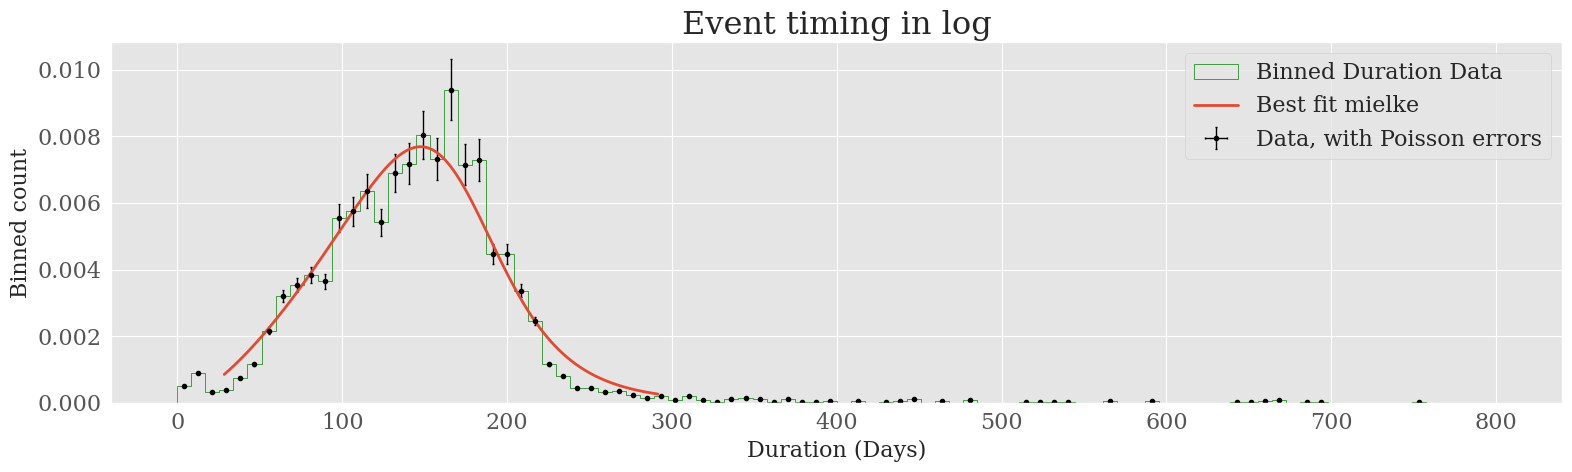

In [102]:
timings = data
Nbins, binwidth = freedman_diaconis_rule(timings)
counts, bin_edges = np.histogram(timings, bins=Nbins, range=(xmin, xmax),density=True)
x = (bin_edges[1:][counts > 0] + bin_edges[:-1][counts > 0]) / 2
y = counts[counts > 0]
sy = np.sqrt(counts[counts > 0])*counts[counts > 0]
fig, ax = plt.subplots(figsize=(16, 5))
counts, bins, bars = ax.hist(timings, bins=Nbins, range=(xmin, xmax), histtype='step',
                                             density=True, alpha=1, color='g',
                                             label='Binned Duration Data')

ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',
                           ecolor='k',
                           elinewidth=1, capsize=1, capthick=1)
f = Fitter(timings, distributions=get_common_distributions(),xmax=xmax,timeout=2*60,bins=Nbins,density=True)
f.fit()
# here you get the rss fit scores
res = f.summary(plot=False)
residual_sumssquare_error = res.iloc[0].sumsquare_error
aic = res.iloc[0].aic
kl_div = res.iloc[0].kl_div
best_dist, fitted_params = f.get_best().popitem()

size = 1000
dist_func = getattr(st,best_dist)
start = dist_func.ppf(0.01, **fitted_params)
end = dist_func.ppf(0.99, **fitted_params)
x = np.linspace(start, end, size)
y = dist_func.pdf(x, **fitted_params)
pdf = pd.Series(y, x)
pdf.plot(lw=2, label=f'Best fit {best_dist}', legend=True)
ax.set_xlabel('Duration (Days)')
ax.set_ylabel('Binned count')
ax.set_title(f'Event timing in log')
ax.legend()
fig.tight_layout()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.000041,3277.065532,-77181.500269,inf,0.083661,6.078141e-26
cauchy,0.000071,1546.291254,-74909.494555,inf,0.076489,9.442029e-22
rayleigh,0.000113,2125.463461,-72947.568649,inf,0.122779,1.818594e-55
expon,0.000451,1426.224007,-67156.431687,inf,0.303183,0.000000e+00
powerlaw,0.000526,1276.431058,-66504.609437,inf,0.449238,0.000000e+00


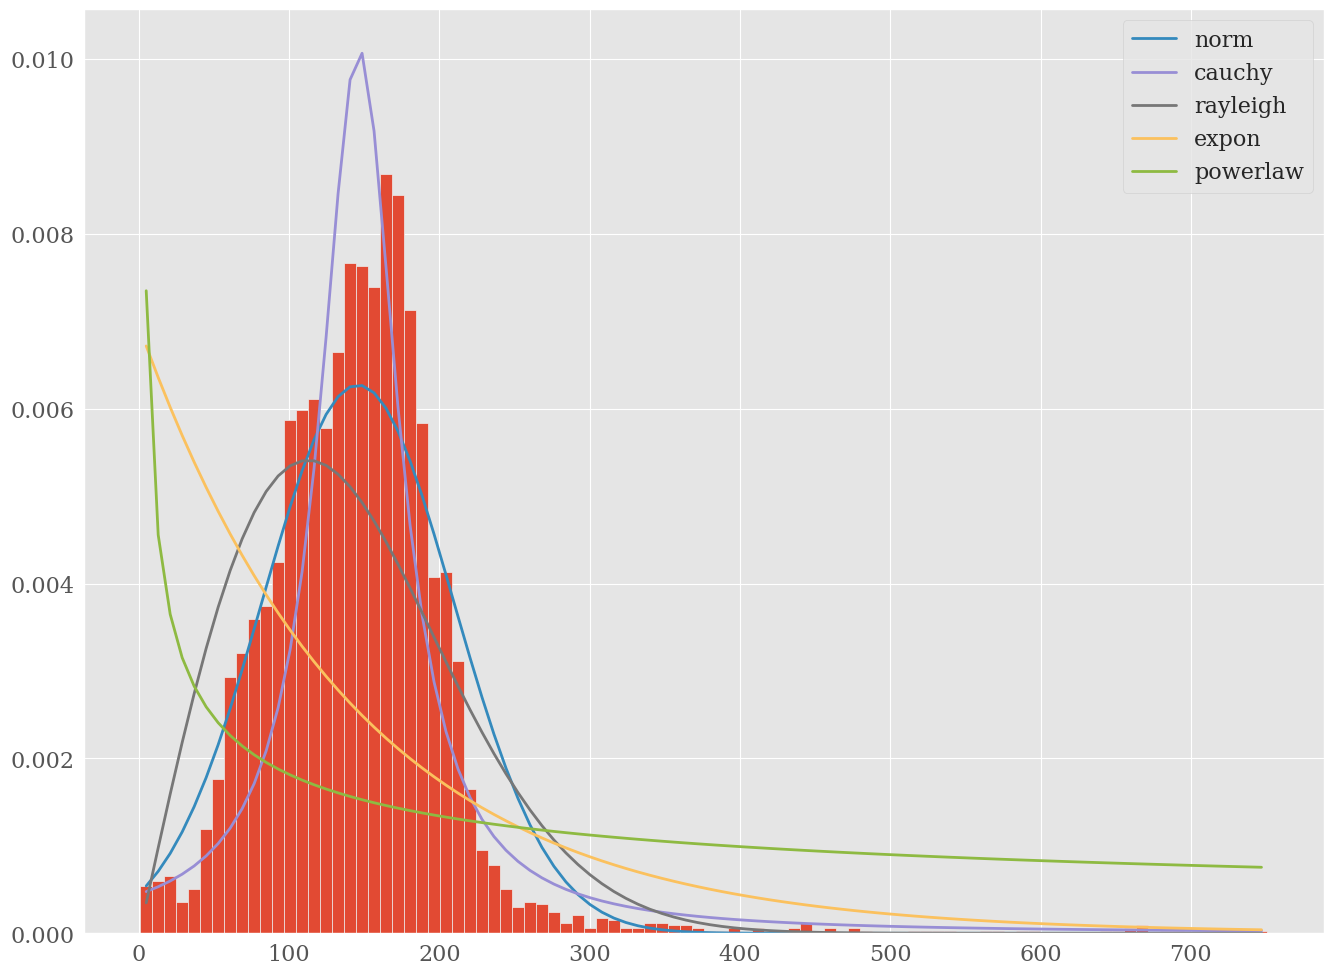

In [97]:
f.summary()

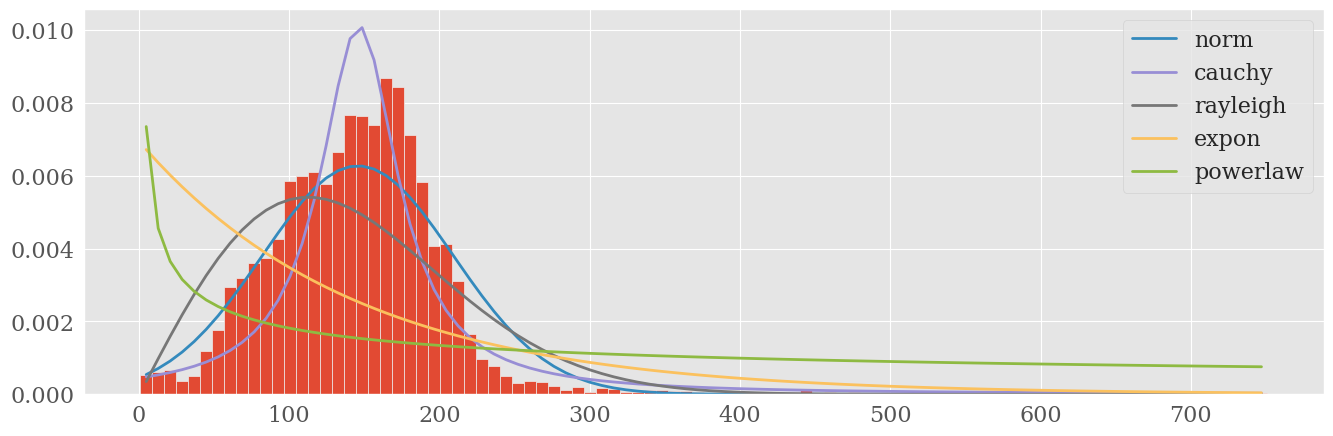

In [99]:
fig, ax = plt.subplots(figsize=(16,5))
fig.set_label(f'Rule {row[0]}: {row[1]} -> {row[2]}')
f.hist()
f.plot_pdf()
plt.savefig(f'Rule {row[0]} - {row[1]} - {row[2]}.png')

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 4.19397e-05] [loc=145.967 scale=64.414]
[distfit] >INFO> [expon     ] [0.02 sec] [RSS: 0.000419821] [loc=1.000 scale=144.967]
[distfit] >INFO> [pareto    ] [0.34 sec] [RSS: 0.000419821] [loc=-8589934591.000 scale=8589934592.000]
[distfit] >INFO> [dweibull  ] [0.36 sec] [RSS: 2.65179e-05] [loc=146.436 scale=45.755]
[distfit] >INFO> [t         ] [1.25 sec] [RSS: 2.33939e-05] [loc=143.360 scale=44.059]
[distfit] >INFO> [genextreme] [1.12 sec] [RSS: 5.61491e-05] [loc=119.055 scale=52.829]
[distfit] >INFO> [gamma     ] [0.61 sec] [RSS: 0.000673666] [loc=1.000 scale=2.038]
[distfit] >INFO> [lognorm   ] [0.59 sec] [RSS: 0.000993042] [loc=1.000 scale=2.618]
[distfit] >INFO> [beta      ] [0.82 sec] [RSS: 4.53151e-05] [loc=-48.951 scale=112754507.408]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.000513834] [loc=1.000 scale=803.000]
[distfit] >INFO> [loggamma  ] [0.56 sec] [RSS: 5.25981e-05] [loc=-2

(<Figure size 2000x1000 with 1 Axes>,
 <Axes: title={'center': 'T (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

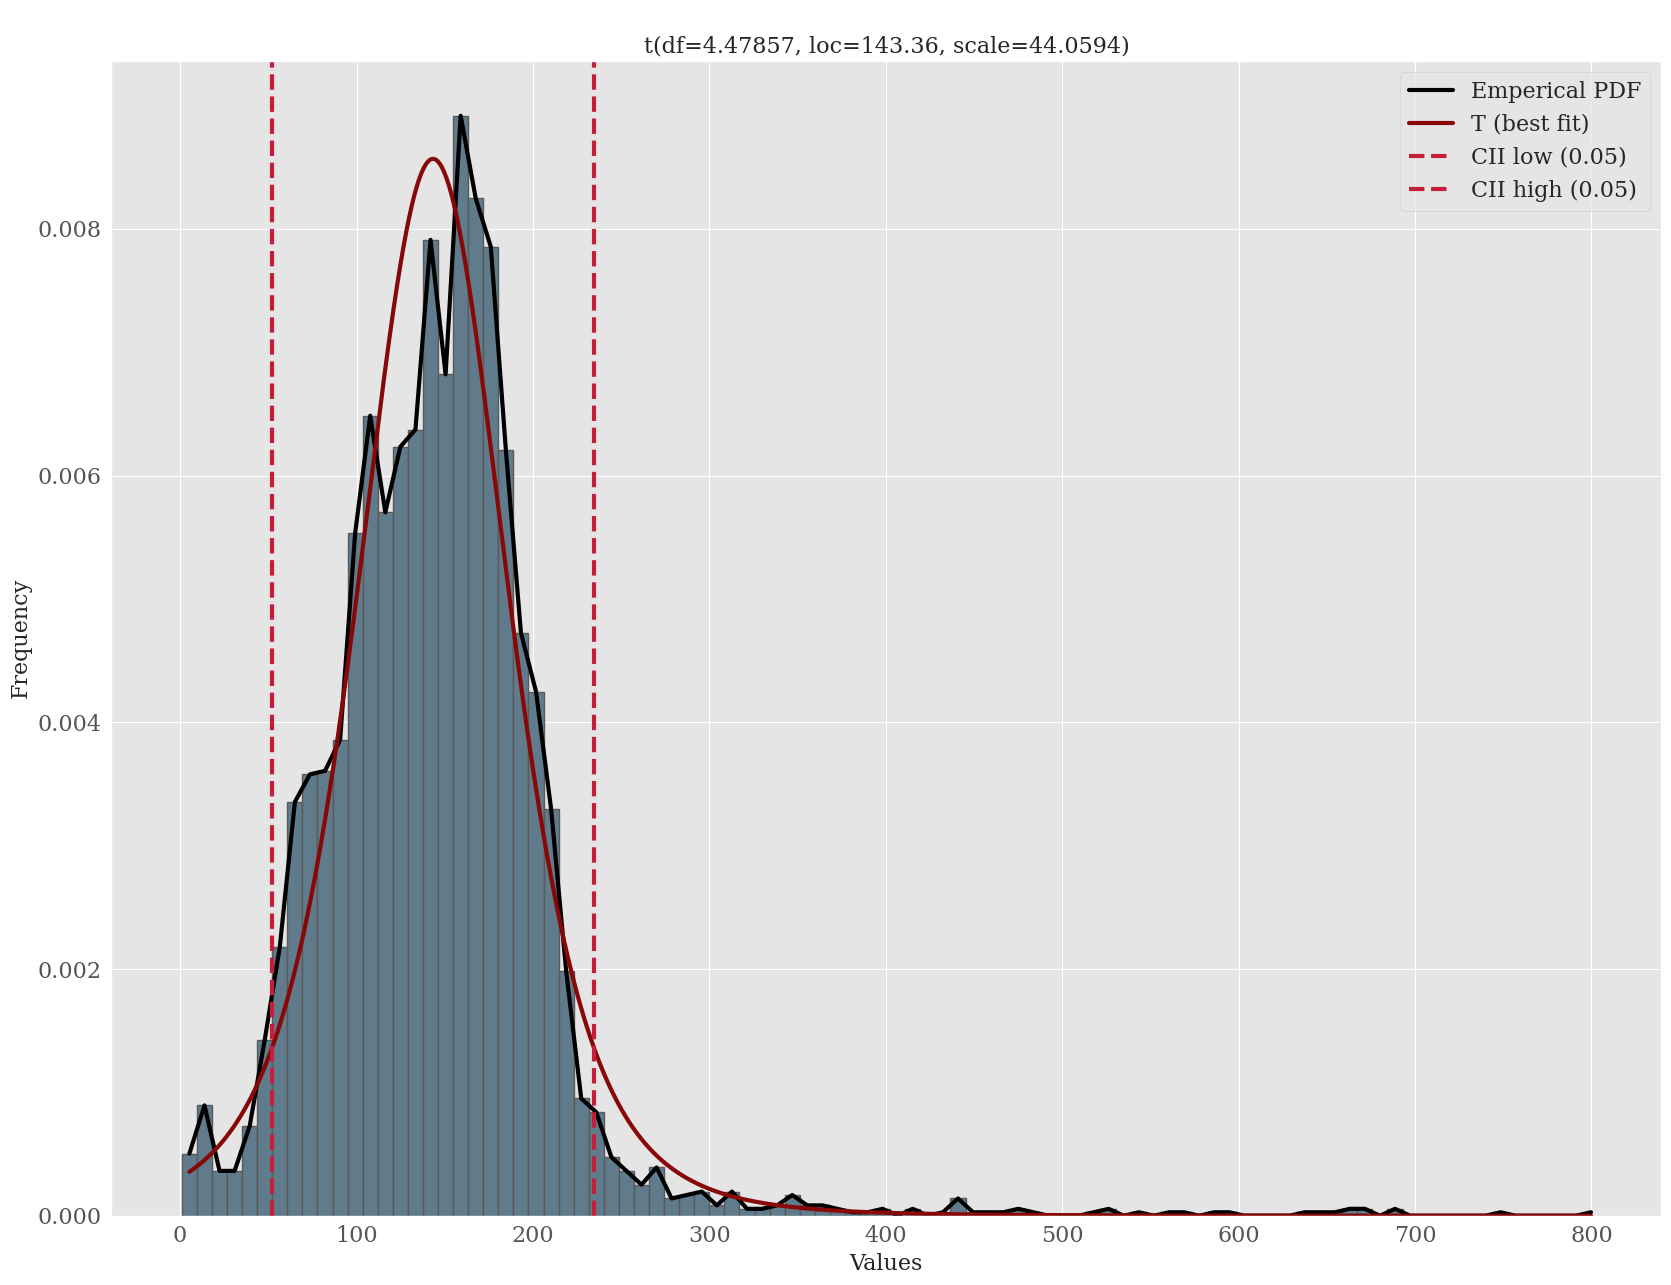

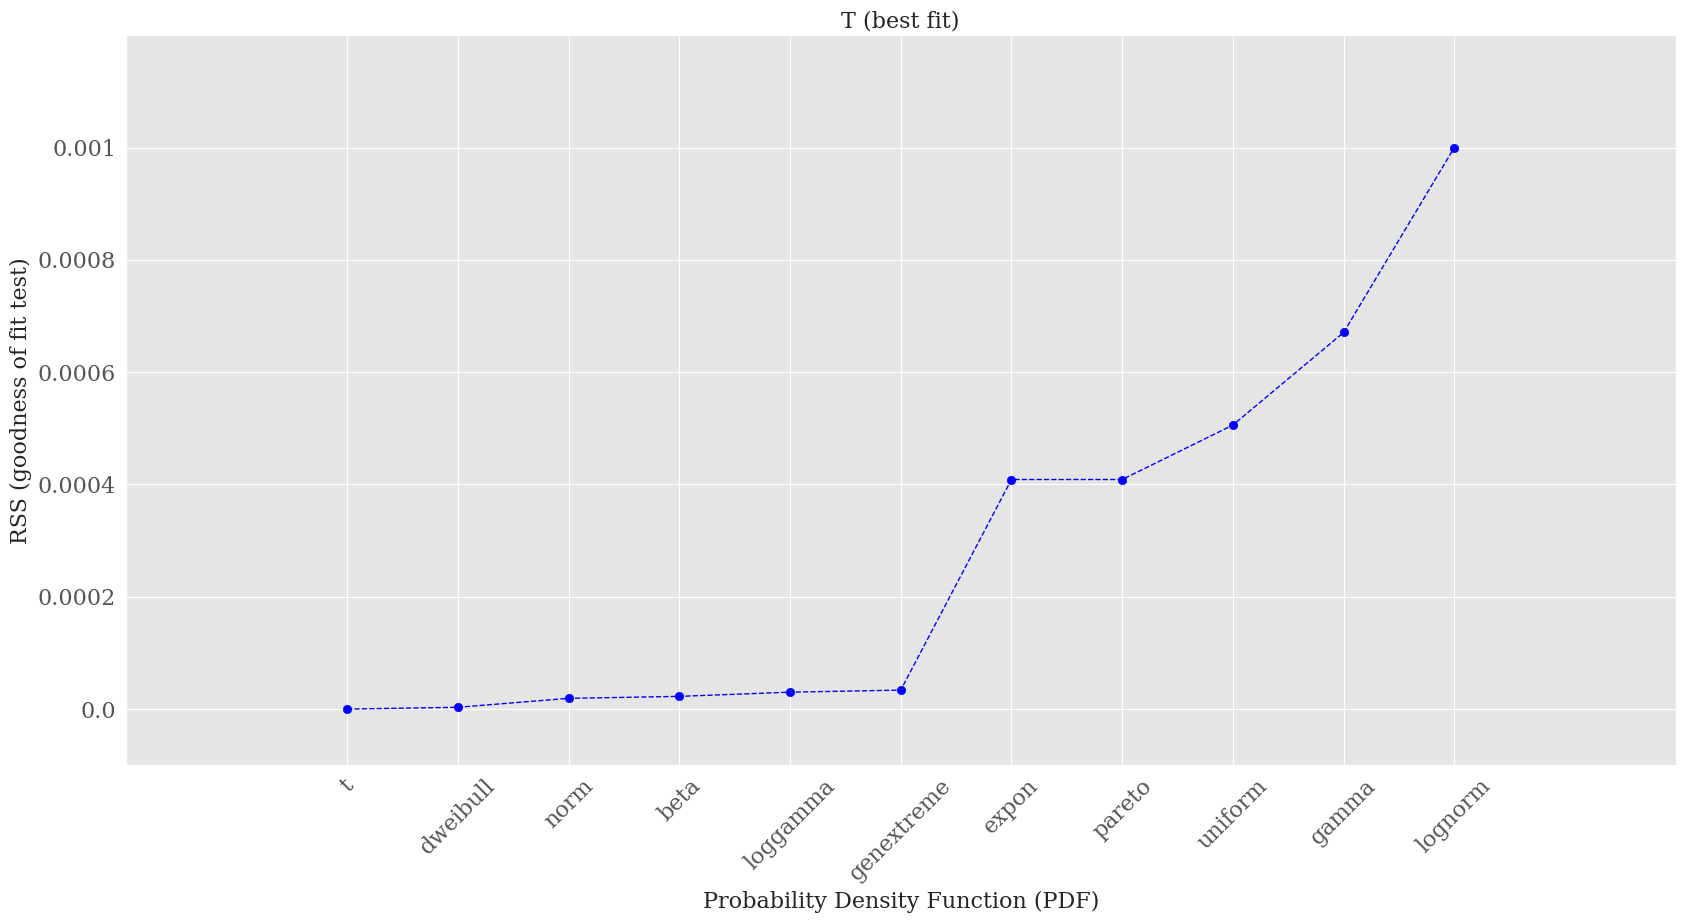

In [104]:
dist = distfit()
dist.fit_transform(X=np.array(data))
distfit_best_fit = dist.summary.iloc[0]['name']
# fig, ax = plt.subplots(figsize=(16,5))
dist.plot()
dist.plot_summary()

In [100]:
print(fitter_best_fit)
print(distfit_best_fit)

norm
t


  1 / 106: ksone
  2 / 106: kstwo
  3 / 106: kstwobign
  4 / 106: norm
  5 / 106: alpha
  6 / 106: anglit
  7 / 106: arcsine
  8 / 106: beta
  9 / 106: betaprime
 10 / 106: bradford
 11 / 106: burr
 12 / 106: burr12
 13 / 106: fisk
 14 / 106: cauchy
 15 / 106: chi
 16 / 106: chi2
 17 / 106: cosine
 18 / 106: dgamma
 19 / 106: dweibull
 20 / 106: expon
 21 / 106: exponnorm
 22 / 106: exponweib
 23 / 106: exponpow
 24 / 106: fatiguelife
 25 / 106: foldcauchy
 26 / 106: f
 27 / 106: foldnorm
 28 / 106: weibull_min
 29 / 106: truncweibull_min
 30 / 106: weibull_max
 31 / 106: genlogistic
 32 / 106: genpareto
 33 / 106: genexpon
 34 / 106: genextreme
 35 / 106: gamma
 36 / 106: erlang
 37 / 106: gengamma
 38 / 106: genhalflogistic
 39 / 106: genhyperbolic
 40 / 106: gompertz
 41 / 106: gumbel_r
 42 / 106: gumbel_l
 43 / 106: halfcauchy
 44 / 106: halflogistic
 45 / 106: halfnorm
 46 / 106: hypsecant
 47 / 106: gausshyper
 48 / 106: invgamma
 49 / 106: invgauss
 50 / 106: geninvgauss
 51 / 1

Text(0, 0.5, 'Binned count')

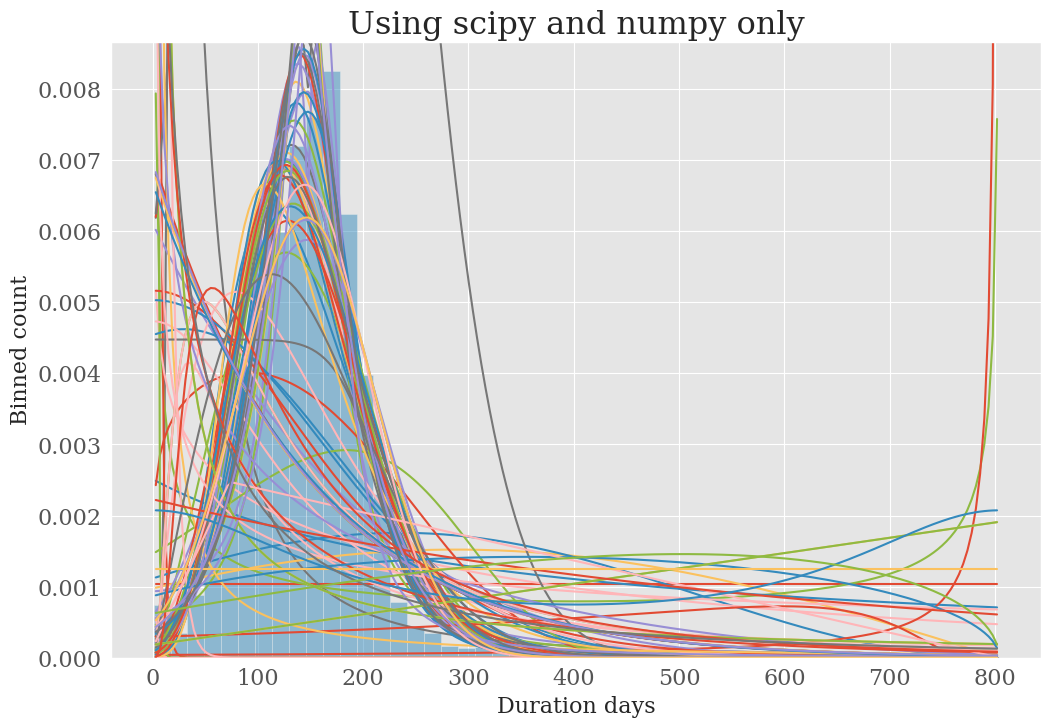

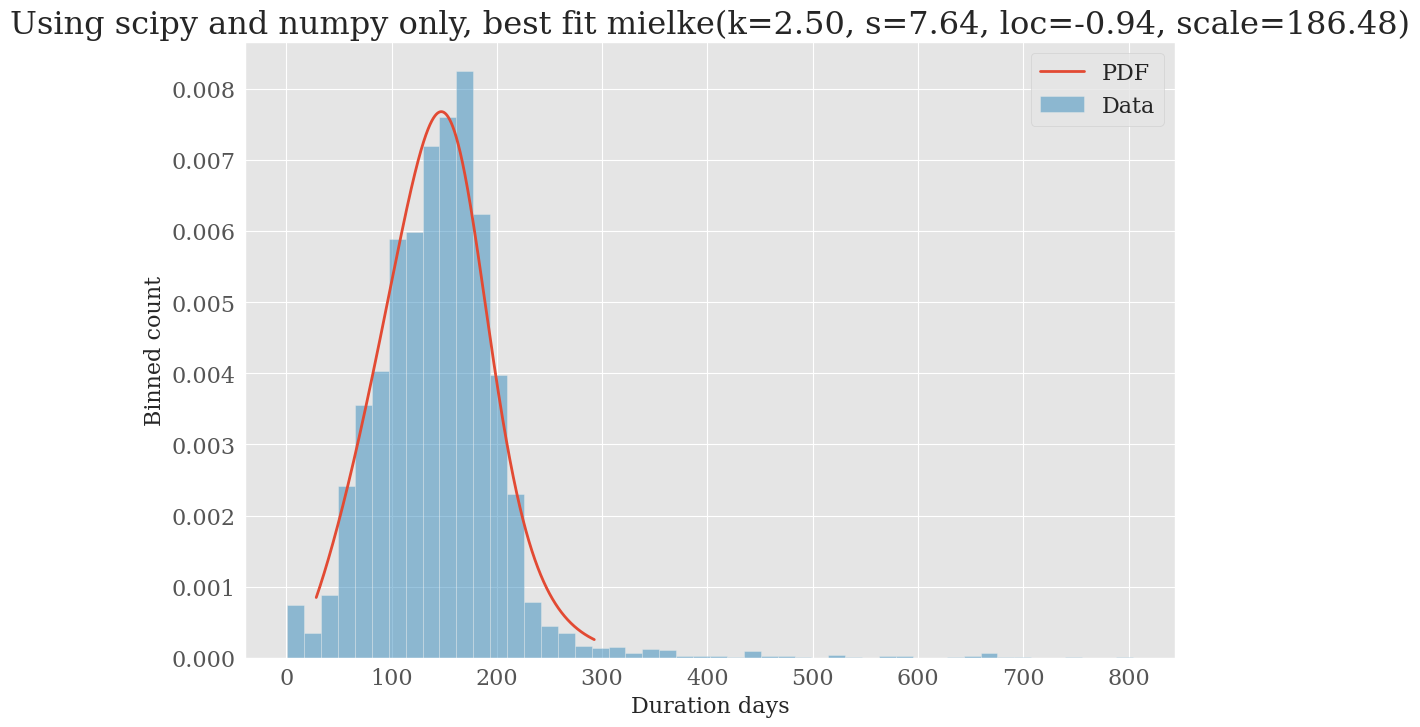

In [106]:
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
# data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

data_series = pd.Series(data)
# Plot for comparison
plt.figure(figsize=(12,8))
ax = data_series.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data_series, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Using scipy and numpy only')
ax.set_xlabel(u'Duration days')
ax.set_ylabel('Binned count')

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data_series.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(f'Using scipy and numpy only, best fit {dist_str}')
ax.set_xlabel(u'Duration days')
ax.set_ylabel('Binned count')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 662                        │              Nfcn = 789              │
│ EDM = 2.13e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_exp    │ 7.2911e3  │ 0.0000e3  │            │            │         │         │       │
│ 1 │ tau      │ 4.4448e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 2 │ N        │    2e3    │    0e3    │            │            │         │         │       │
│ 3 │ mu       │  8.4098   │  0.0000   │            │            │         │         │       │
│ 4 │ sigma    │ 1.0471e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 5 │ N2       │ 1.8918e3  │ 0.0000e3  │            │            │         │         │       │
│ 6 │ mu2      │   4.936   │   0.000   │            │            │         │         │       │
│ 7 │ sigma2   │ 3.2019e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 8 │ binwidth │ 1.5781e1  │ 0.0000e1  │            │            │         │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

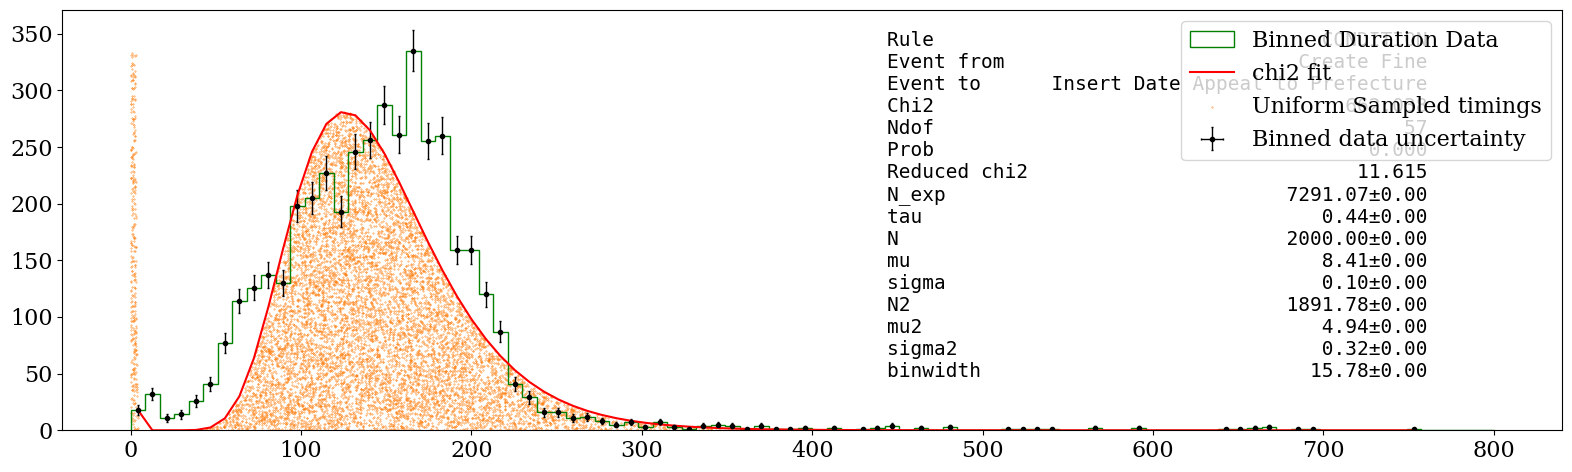

In [88]:
fig, ax = plt.subplots(figsize=(16,5))
counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Binned data uncertainty', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

initial_values_dict = {
    'N_exp':10000,
    'tau': 1/np.e,
    'N': 2000,
    'mu': np.log(50),
    'sigma': np.log(10),
    'N2': 1000,
    'mu2': np.log(140),
    'sigma2': np.log(10),
    'binwidth': binwidth
}
func_to_fit = double_log_gaussian_exp
minuit_fit, fit_info = fit_chi2_minuit(func_to_fit,initial_values_dict,x,y,sy)

pred_y = []
for k in x:
    pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
pred_y = np.array(pred_y)
ax.plot(x, pred_y, '-r',label='chi2 fit')     # Note how we can "smartly" input the fit values!


d = {
 'Rule':      row[0],
 'Event from':      row[1],
 'Event to':     row[2],
}
to_print = {}
pm = u"\u00B1"
for k,v in minuit_fit.values.to_dict().items():
    to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
d = {**d,**fit_info}
d = {**d, **to_print}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.55, 0.95, text, ax, fontsize=14)

x_sampled, y_sampled = sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
ax.scatter(x_sampled,y_sampled, s=.1, label='Uniform Sampled timings')

ax.legend()
fig.tight_layout()
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
minuit_fit

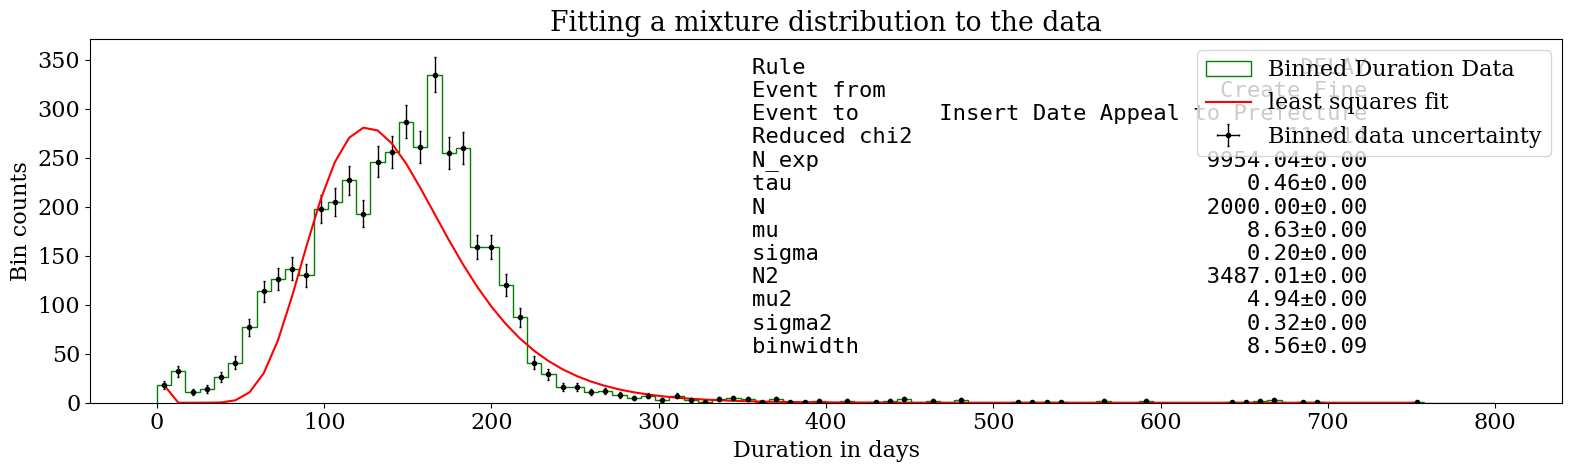

In [89]:
fig, ax = plt.subplots(figsize=(16,5))
counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Binned data uncertainty', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

initial_values_dict = {
    'N_exp':10000,
    'tau': 1/np.e,
    'N': 2000,
    'mu': np.log(50),
    'sigma': np.log(10),
    'N2': 1000,
    'mu2': np.log(140),
    'sigma2': np.log(10),
    'binwidth':binwidth
}
func_to_fit = double_log_gaussian_exp
#minuit_fit = fit_ls_minuit(func_to_fit,initial_values_dict,x,y,sy)

custom_initial_values_dict = {
    'N_exp':4000,
    'loc_exp':0,
    'scale_exp':1,
    'N':1000,
    'loc':50,
    'scale':14,
    'N2':2000,
    'loc2':140,
    'scale2':10,
    'binwidth':binwidth
}


def double_log_gaussian_exp(x,N_exp, tau,N,mu,sigma,N2,mu2,sigma2,binwidth):
    return N_exp*binwidth*exp_pdf(x,tau) + N*binwidth*log_gauss_pdf(x,mu,sigma) + N2*binwidth*log_gauss_pdf(x,mu2,sigma2)

# ,
def custom_pdf(x,N_exp,loc_exp,scale_exp, N, loc, scale, N2, loc2, scale2,binwidth):
    """Gaussian"""
    return N_exp*binwidth*expon.pdf(x,loc_exp,scale_exp) + \
            N*binwidth*norm.pdf(x, loc, scale) + \
            N2*binwidth*norm.pdf(x, loc2, scale2)
Minuit.print_level = 1
ls_fit = cost.LeastSquares(x, y, sy, func_to_fit)
minuit_fit = Minuit(ls_fit, **initial_values_dict)
minuit_fit.fixed['binwidth'] = True
minuit_fit.migrad()       # Perform the actual fit

ls_fit = minuit_fit.fval


pred_y = []
for k in x:
    pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
pred_y = np.array(pred_y)
ax.plot(x, pred_y, '-r',label='least squares fit')     # Note how we can "smartly" input the fit values!


d = {
 'Rule':      'DELAY',
 'Event from':      row[1],
 'Event to':     row[2],
}
to_print = {}
to_print['Reduced chi2'] = minuit_fit.fval / (len(y) - minuit_fit.nfit)  # reduced chi2
pm = u"\u00B1"
for k,v in minuit_fit.values.to_dict().items():
    to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
#d = {**d,**fit_info}
d = {**d, **to_print}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.45, 0.95, text, ax, fontsize=16)

#x_sampled, y_sampled = sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
#ax.scatter(x_sampled,y_sampled, s=.1, label='Uniform Sampled timings')
ax.set_xlabel('Duration in days')
ax.set_ylabel('Bin counts')
ax.set_title('Fitting a mixture distribution to the data')
ax.legend()
fig.tight_layout()
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
minuit_fit
plt.savefig('mixturefit_createfine_sendfine.png')

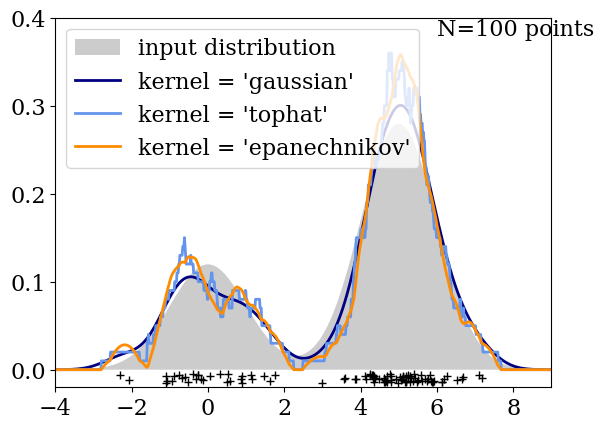

In [90]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

N = 100
np.random.seed(1)
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

In [92]:
import numpy as np
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=4, random_state=0).fit(np.array(data).reshape(-1,1))
gm.means_

array([[ 83.91695979],
       [184.10682542],
       [319.19650248],
       [141.05610342]])

In [93]:
gm.predict([[40],[110]])

array([0, 3])

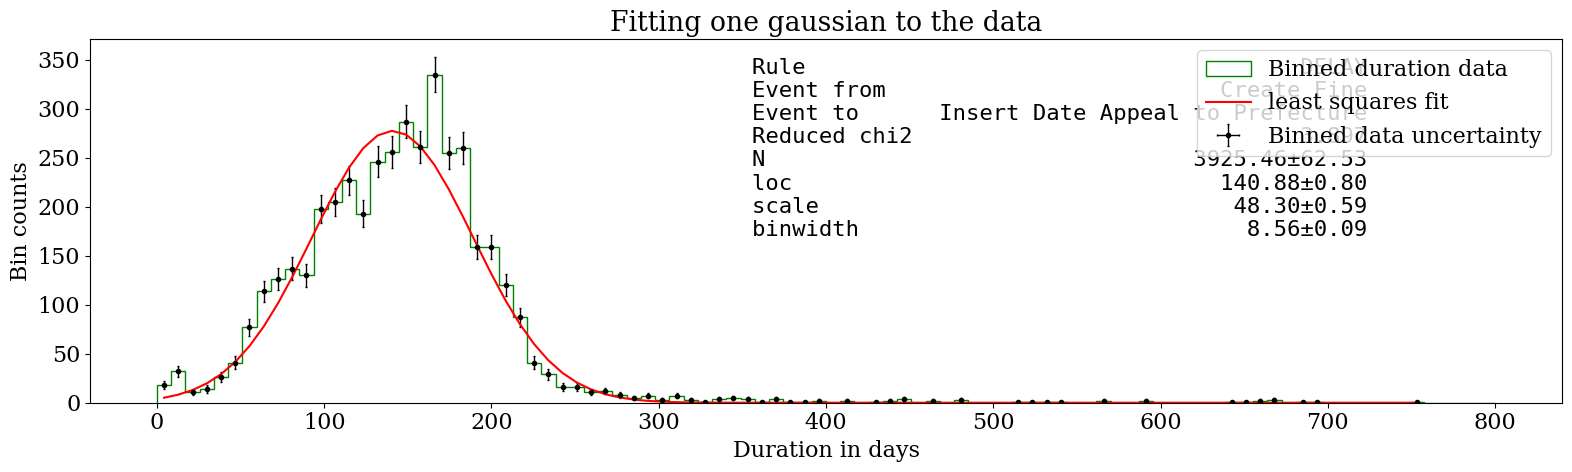

In [94]:
def fit_ls_minuit(function_to_fit, initial_values_dict, x, y, sy, err_def=1):
    """Fit any defined function using least squares
    NOTE: All fixed parameters that are part of the 'function_to_fit'
    need to be initialized before this method call
    
    Parameters:
    function_to_fit: the function to fit the data to can be anything (gaussian, exp, exp+gauss,a+b)
    initial_values_dict: a dictionary of key value pairs that are the initial input to the function_to_fit
    x: input training data
    y: result training data
    sy: errors on the output (if data is binned errors are poisson)
    err_def: 1: ls fit 0.5: likelihood fit
   
    returns: Chi2, Ndof, Prob
    """
    Minuit.print_level = 1
    ls_fit = cost.LeastSquares(x, y, sy, function_to_fit)
    minuit_fit = Minuit(ls_fit, **initial_values_dict)   
    minuit_fit.migrad()       # Perform the actual fit

    ls_fit = minuit_fit.fval
    return minuit_fit

#'norm': {'loc': 85.13093521722415, 'scale': 42.078394977302224}

def N_gauss_pdf(x, N, loc, scale,binwidth):
    """Gaussian"""
    return N*binwidth*norm.pdf(x, loc, scale)

fig, ax = plt.subplots(figsize=(16,5))
counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned duration data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Binned data uncertainty', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)


initial_values_dict = {
    'N': 2000,
    'loc': 85,
    'scale': 42,
    'binwidth':binwidth
}
func_to_fit = N_gauss_pdf
#minuit_fit = fit_ls_minuit(func_to_fit,initial_values_dict,x,y,sy)

Minuit.print_level = 1
ls_fit = cost.LeastSquares(x, y, sy, func_to_fit)
minuit_fit = Minuit(ls_fit, **initial_values_dict)
minuit_fit.fixed['binwidth'] = True
minuit_fit.migrad()       # Perform the actual fit

ls_fit = minuit_fit.fval


pred_y = []
for k in x:
    pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
pred_y = np.array(pred_y)
ax.plot(x, pred_y, '-r',label='least squares fit')     # Note how we can "smartly" input the fit values!


d = {
 'Rule':      'DELAY',
 'Event from':      row[1],
 'Event to':     row[2],
}
to_print = {}
to_print['Reduced chi2'] = minuit_fit.fval / (len(y) - minuit_fit.nfit)  # reduced chi2
pm = u"\u00B1"
for k,v in minuit_fit.values.to_dict().items():
    to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
#d = {**d,**fit_info}
d = {**d, **to_print}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.45, 0.95, text, ax, fontsize=16)

#x_sampled, y_sampled = sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
#ax.scatter(x_sampled,y_sampled, s=.1, label='Uniform Sampled timings')
ax.set_xlabel('Duration in days')
ax.set_ylabel('Bin counts')
ax.set_title('Fitting one gaussian to the data')
ax.legend()
fig.tight_layout()
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
minuit_fit
plt.savefig('simplefit_createfine_sendfine.png')

In [95]:
def get_boxplot_values(data):
    median = np.median(data)
    upper_quartile = np.percentile(data, 75)
    lower_quartile = np.percentile(data, 25)

    iqr = upper_quartile - lower_quartile
    upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
    lower_whisker = data[data>=lower_quartile-1.5*iqr].min()
    min = data.min()
    max = data.max()
    mean = np.mean(data)
    return (lower_whisker,lower_quartile,median,upper_quartile,upper_whisker,iqr,min,max,mean)

## Descriptive statistics between Create fine and send fine

TypeError: only integer scalar arrays can be converted to a scalar index

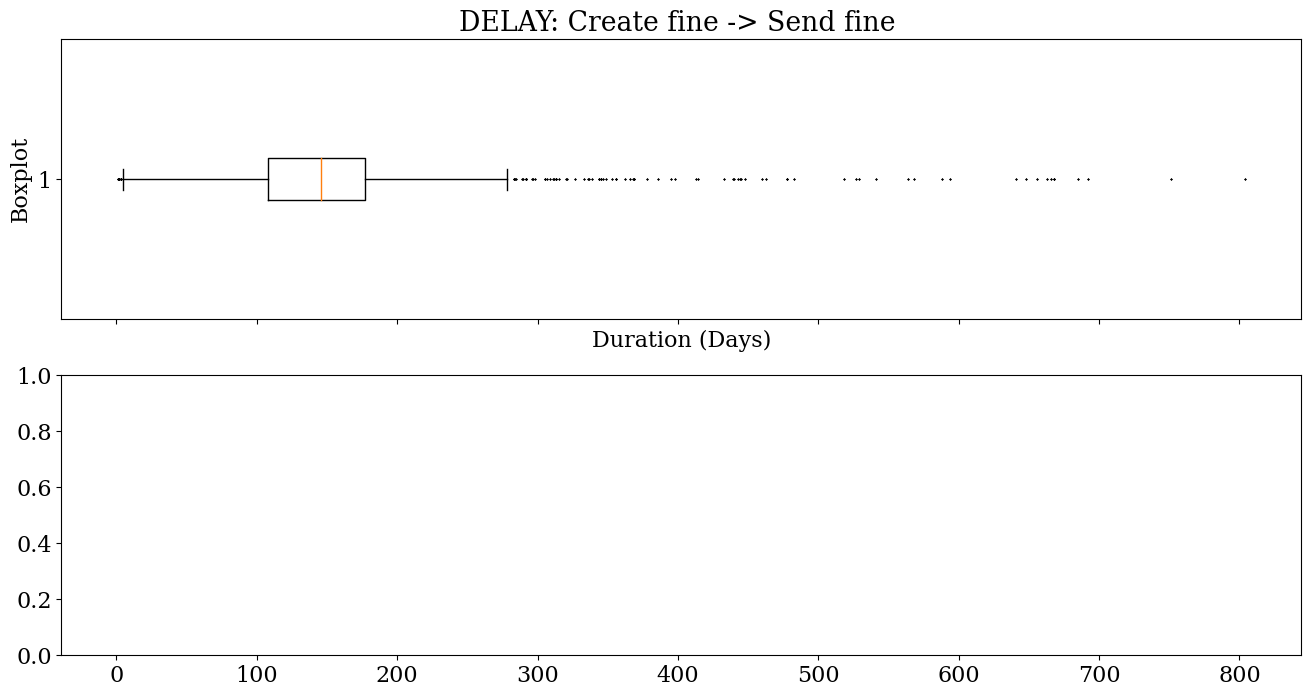

In [96]:
Nbins, _ = freedman_diaconis_rule(data)
counts, bin_edges = np.histogram(data,bins=Nbins,range=(xmin,xmax))
# take only non empty bins, that's why counts>0
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
figs, axs = plt.subplots(2,1,figsize=(16,8),sharex=True)
ax = axs[0]
ax.boxplot(data,vert=False,flierprops={'marker':'x', 'markerfacecolor':'r', 'markersize':1})
ax.set_xlabel('Duration (Days)')
ax.set_ylabel('Boxplot')
ax.set_title('DELAY: Create fine -> Send fine ')

lower_whisker,lower_quartile,median,upper_quartile,upper_whisker,iqr,dmin,dmax,mean = get_boxplot_values(data)

d = {'Lower whisker':lower_whisker,
    'Lower quartile':lower_quartile,
    'Median':median,
    'Upper quartile':upper_quartile,
    'Upper whisker':upper_whisker,
    'IQR':iqr}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.70, 0.95, text, ax, fontsize=16)

ax = axs[1]
ax.set(xlim=(xmin-1, xmax))
ax.hist(data, bins=Nbins, range=(xmin, xmax), histtype='step', density=False, alpha=1, color='g',
        label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax.set_xlabel('Duration (Days)')
ax.set_ylabel('Binned count')

d = {
    'Min':dmin,
    'Max':dmax,
    'Mean':mean}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.70, 0.95, text, ax, fontsize=16)

plt.tight_layout()
plt.savefig('box_hist_create_fine_send_fine.png')

In [97]:
np.max(data)

804

In [98]:
np.min(data)

1

In [99]:
np.median(data)

146.0

In [100]:
np.mean(data)

145.96728748806112

## 1: CONDITION   ['Send Fine', 'Insert Fine Notification'] 79860

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4137 (χ²/ndof = 71.3)      │             Nfcn = 1332              │
│ EDM = 0.000536 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_exp  │  67.0e3   │   0.5e3   │            │            │         │         │       │
│ 1 │ tau    │ 918.01e-3 │  0.10e-3  │            │            │         │         │       │
│ 2 │ N      │   -9e3    │    5e3    │            │            │         │         │       │
│ 3 │ mu     │   11.01   │   0.09    │            │            │         │         │       │
│ 4 │ sigma  │   -0.46   │   0.04    │            │            │         │         │       │
│ 5 │ N2     │  3.61e3   │  0.24e3   │            │            │         │         │       │
│ 6 │ mu2    │   1.73    │   0.04    │            │            │         │         │       │
│ 7 │ sigma2 │   -0.25   │   0.08    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │          N_exp            tau              N             mu          sigma             N2            mu2         sigma2 │
├────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  N_exp │       2.69e+05   20.782419e-3        -2.42e6        -44.477        21.4228        -0.12e6       -18.7536         41.091 │
│    tau │   20.782419e-3       9.32e-09 -193.312559e-3      -3.555e-6       1.713e-6   -9.895643e-3      -1.498e-6       3.281e-6 │
│      N │        -2.42e6 -193.312559e-3       2.19e+07        401.227      -193.2329         1.13e6       169.1970       -370.745 │
│     mu │        -44.477      -3.555e-6        401.227        0.00738        -0.0036         20.661         0.0031         -0.007 │
│  sigma │        21.4228       1.713e-6      -193.2329        -0.0036        0.00171        -9.9515        -0.0015         0.0033 │
│     N2 │        -0.12e6   -9.895643e-3         1.13e6         20.661        -9.9515        5.8e+04         8.7122        -19.090 │
│    mu2 │       -18.7536      -1.498e-6       169.1970         0.0031        -0.0015         8.7122        0.00131        -0.0029 │
│ sigma2 │         41.091       3.281e-6       -370.745         -0.007         0.0033        -19.090        -0.0029        0.00629 │
└────────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

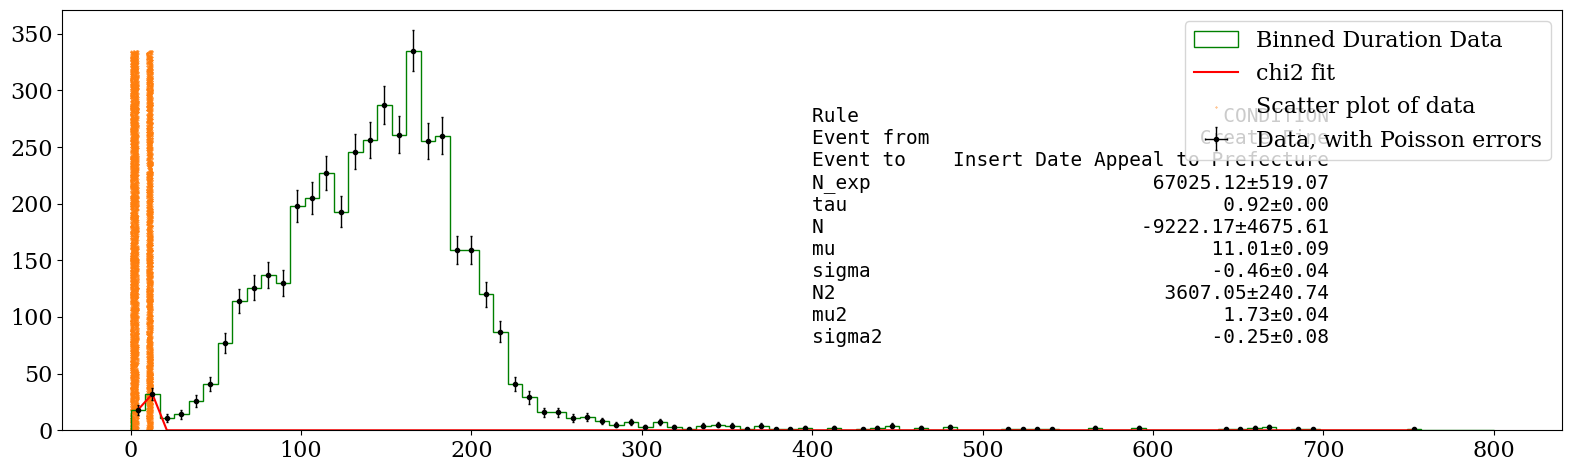

In [104]:
fig, ax = plt.subplots(figsize=(16,5))
row,data,Nbins,x,y,sy,binwidth = data_dict[1]
counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

initial_values_dict = {
    'N_exp':100000,
    'tau': 1.0,
    'N': 2000,
    'mu': 10,
    'sigma': 4,
    'N2': 1000,
    'mu2': np.log(19),
    'sigma2': np.log(3)
}

func_to_fit = gaus_log_gauss_exp#double_log_gaussian_exp

#not a chi2 fit
minuit_fit = fit_minuit(func_to_fit,initial_values_dict,x,y,sy)

pred_y = []
for k in x:
    pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
pred_y = np.array(pred_y)
ax.plot(x, pred_y, '-r',label='chi2 fit')     # Note how we can "smartly" input the fit values!



d = {
 'Rule':      row[0],
 'Event from':      row[1],
 'Event to':     row[2],
}
to_print = {}
pm = u"\u00B1"
for k,v in minuit_fit.values.to_dict().items():
    to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
# d = {**d,**fit_info}
d = {**d, **to_print}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.50, 0.77, text, ax, fontsize=14)


x_sampled, y_sampled = sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
ax.scatter(x_sampled,y_sampled, s=.1, label='Scatter plot of data')

ax.legend()
fig.tight_layout()
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
minuit_fit

## 2: CONDITION   ['Insert Fine Notification', 'Add penalty'] 79860

In [107]:
row,data,Nbins,x,y,sy,binwidth = data_dict[2]
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],'x',{'x':60.0}]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
print(row)
print(min(data),max(data))
print(f'This condition is consistently {np.median(data)} days. No fit necessary')

('CONDITION', 'Insert Fine Notification', 'Notify Result Appeal to Offender')
37 561
This condition is consistently 160.0 days. No fit necessary


## 3: CONDITION   ['Create Fine', 'Add penalty'] 79860

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

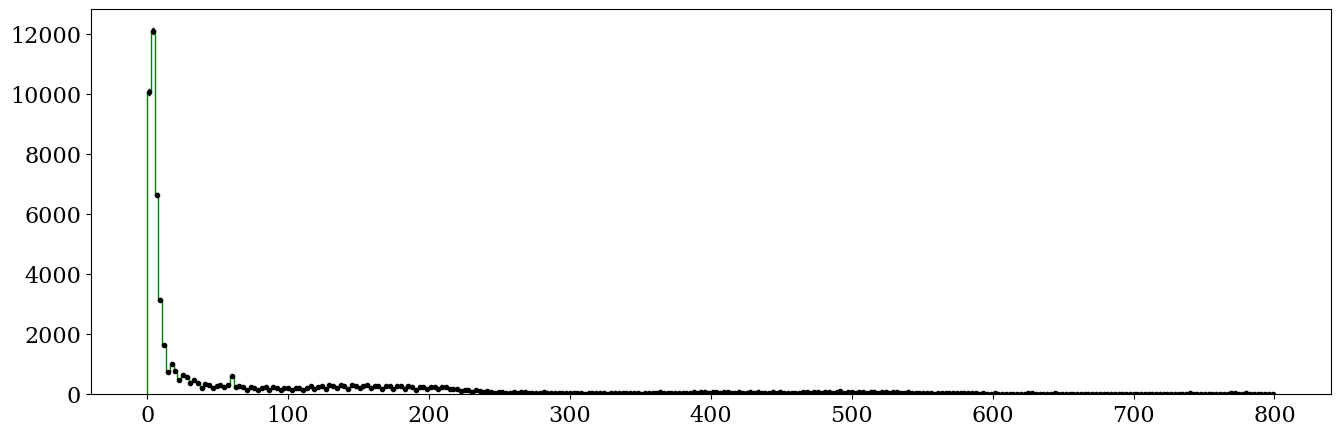

In [108]:
fig, ax = plt.subplots(figsize=(16,5))
row,data,Nbins,x,y,sy,binwidth = data_dict[3]
counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

initial_values_dict = {
    'N': 100,
    'mu': 60,
    'sigma': 0.5,
    'N2': 1000,
    'mu2': np.log(120),
    'sigma2': np.log(15),
    'N3': 2000,
    'mu3': np.log(205),
    'sigma3': np.log(20)
}
func_to_fit = triple_gauss_log_log
minuit_fit, fit_info = fit_minuit(func_to_fit,initial_values_dict,x,y,sy)

pred_y = []
for k in x:
    pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
pred_y = np.array(pred_y)
ax.plot(x, pred_y, '-r',label='chi2 fit')     # Note how we can "smartly" input the fit values!



d = {
 'Rule':      row[0],
 'Event from':      row[1],
 'Event to':     row[2],
}
to_print = {}
pm = u"\u00B1"
for k,v in minuit_fit.values.to_dict().items():
    to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
d = {**d,**fit_info}
d = {**d, **to_print}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.50, 0.77, text, ax, fontsize=14)


x_sampled, y_sampled = sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
ax.scatter(x_sampled,y_sampled, s=.1, label='Scatter plot of data')

ax.legend()
fig.tight_layout()
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
minuit_fit

## 4 CONDITION   ['Add penalty', 'Send for Credit Collection'] 16

Not enough data points for making time estimates of this rule

TODO: Make a mean value approximation

## 5: CONDITION   ['Send Fine', 'Send for Credit Collection'] 16

Not enough data points for making time estimates of this rule

TODO: Make a mean value approximation

## 6: CONDITION   ['Create Fine', 'Payment'] 10033

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
data,Nbins,x,y,sy,row,binwidth = data_dict[6]
counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

initial_values_dict = {
    'N_exp':1000,
    'tau': 1/np.e,
    'N': 100,
    'mu': np.log(90),
    'sigma': np.log(10),
    'N2': 120,
    'mu2': np.log(190),
    'sigma2': np.log(10),
    'binwidth':binwidth
}

func_to_fit = double_log_gaussian_exp
minuit_fit, fit_info = fit_minuit(func_to_fit,initial_values_dict,x,y,sy)

pred_y = []
for k in x:
    pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
pred_y = np.array(pred_y)
ax.plot(x, pred_y, '-r',label='chi2 fit')     # Note how we can "smartly" input the fit values!



d = {
 'Rule':      row[0],
 'Event from':      row[1],
 'Event to':     row[2],
}
to_print = {}
pm = u"\u00B1"
for k,v in minuit_fit.values.to_dict().items():
    to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
d = {**d,**fit_info}
d = {**d, **to_print}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.50, 0.77, text, ax, fontsize=14)

x_sampled, y_sampled = sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
ax.scatter(x_sampled,y_sampled, s=.1, label='Scatter plot of data')

ax.legend()
fig.tight_layout()
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
minuit_fit

## 7: CONDITION   ['Create Fine', 'Insert Date Appeal to Prefecture'] 4188

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
data,Nbins,x,y,sy,row,binwith = data_dict[7]
counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

initial_values_dict = {
    #'N_exp':1000,
    #'tau': 1/np.e,
    'N': 1000,
    'mu': 90,
    'sigma': 10,
    'N2': 200,
    'mu2': 19,
    'sigma2': 4,
    'N3': 1200,
    'mu3': np.log(190),
    'sigma3':np.log(10)
}

func_to_fit = triple_gauss_gauss_log #triple_gaussian #double_log_gaussian_exp
minuit_fit, fit_info = fit_minuit(func_to_fit,initial_values_dict,x,y,sy)

pred_y = []
for k in x:
    pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
pred_y = np.array(pred_y)
ax.plot(x, pred_y, '-r',label='chi2 fit')     # Note how we can "smartly" input the fit values!



d = {
 'Rule':      row[0],
 'Event from':      row[1],
 'Event to':     row[2],
}
to_print = {}
pm = u"\u00B1"
for k,v in minuit_fit.values.to_dict().items():
    to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
d = {**d,**fit_info}
d = {**d, **to_print}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.50, 0.77, text, ax, fontsize=14)

x_sampled, y_sampled = sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
ax.scatter(x_sampled,y_sampled, s=.1, label='Scatter plot of data')

ax.legend()
fig.tight_layout()
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
minuit_fit

## 8: CONDITION   ['Create Fine', 'Send Appeal to Prefecture'] 997

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
data,Nbins,x,y,sy,row,binwidth = data_dict[8]
counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

initial_values_dict = {
    'N': 499,
    'mu': 120,
    'sigma': 20,
    'N2': 200,
    'mu2': 200,
    'sigma2': 10
}
func_to_fit = double_gaussian
minuit_fit, fit_info = fit_minuit(func_to_fit,initial_values_dict,x,y,sy)

pred_y = []
for k in x:
    pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
pred_y = np.array(pred_y)
ax.plot(x, pred_y, '-r',label='chi2 fit')     # Note how we can "smartly" input the fit values!



d = {
 'Rule':      row[0],
 'Event from':      row[1],
 'Event to':     row[2],
}
to_print = {}
pm = u"\u00B1"
for k,v in minuit_fit.values.to_dict().items():
    to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
d = {**d,**fit_info}
d = {**d, **to_print}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.50, 0.77, text, ax, fontsize=14)

x_sampled, y_sampled = sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
ax.scatter(x_sampled,y_sampled, s=.1, label='Scatter plot of data')

ax.legend()
fig.tight_layout()
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
minuit_fit

## 9: CONDITION   ['Send Fine', 'Receive Result Appeal from Prefecture'] 946

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
data,Nbins,x,y,sy,row,binwidth = data_dict[9]
counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

initial_values_dict = {
    'N':400,
    'mu': np.log(120),
    'sigma': np.log(40)
}
func_to_fit = N_log_gauss_pdf
minuit_fit = fit_minuit(func_to_fit,initial_values_dict,x,y,sy)

pred_y = []
for k in x:
    pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
pred_y = np.array(pred_y)
ax.plot(x, pred_y, '-r',label='chi2 fit')     # Note how we can "smartly" input the fit values!



d = {
 'Rule':      row[0],
 'Event from':      row[1],
 'Event to':     row[2],
}
to_print = {}
pm = u"\u00B1"
for k,v in minuit_fit.values.to_dict().items():
    to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
d = {**d,**fit_info}
d = {**d, **to_print}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.50, 0.77, text, ax, fontsize=14)

# x_sampled, y_sampled = sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
# ax.scatter(x_sampled,y_sampled, s=.1, label='Scatter plot of data')

ax.legend()
fig.tight_layout()
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
minuit_fit

## 10: CONDITION   ['Insert Fine Notification', 'Notify Result Appeal to Offender'] 810

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
data,Nbins,x,y,sy,row,binwidth = data_dict[10]
counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

initial_values_dict = {
    'N':300,
    'mu': np.log(120),
    'sigma': np.log(30)
}
func_to_fit = N_log_gauss_pdf
minuit_fit = fit_minuit(func_to_fit,initial_values_dict,x,y,sy)

pred_y = []
for k in x:
    pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
pred_y = np.array(pred_y)
ax.plot(x, pred_y, '-r',label='chi2 fit')     # Note how we can "smartly" input the fit values!



d = {
 'Rule':      row[0],
 'Event from':      row[1],
 'Event to':     row[2],
}
to_print = {}
pm = u"\u00B1"
for k,v in minuit_fit.values.to_dict().items():
    to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
d = {**d,**fit_info}
d = {**d, **to_print}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.50, 0.77, text, ax, fontsize=14)

#x_sampled, y_sampled = sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
#ax.scatter(x_sampled,y_sampled, s=.1, label='Scatter plot of data')

ax.legend()
fig.tight_layout()
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
minuit_fit

## 11: CONDITION   ['Create Fine', 'Notify Result Appeal to Offender'] 810

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
data,Nbins,x,y,sy,row,binwidth = data_dict[11]
counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

initial_values_dict = {
    'N':200,
    'mu': 275,
    'sigma': 77
}
func_to_fit = N_gauss_pdf
minuit_fit = fit_minuit(func_to_fit,initial_values_dict,x,y,sy)

pred_y = []
for k in x:
    pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
pred_y = np.array(pred_y)
ax.plot(x, pred_y, '-r',label='least squares fit')     # Note how we can "smartly" input the fit values!



d = {
 'Rule':      'DELAY',
 'Event from':      row[1],
 'Event to':     row[2],
 'Reduced chi2': minuit_fit.fval / (len(y) - minuit_fit.nfit)  # reduced chi2
}
to_print = {}
pm = u"\u00B1"
for k,v in minuit_fit.values.to_dict().items():
    to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
# d = {**d,**fit_info}
d = {**d, **to_print}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.55, 0.60, text, ax, fontsize=16)

# x_sampled, y_sampled = sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
# ax.scatter(x_sampled,y_sampled, s=.1, label='Scatter plot of data')

ax.legend()
fig.tight_layout()
ax.set_xlabel('Duration in days')
ax.set_ylabel('Bin counts')
ax.set_title('Fitting a single gaussian distribution to the data')
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
minuit_fit
plt.savefig('single_gaussian.png')

## 12: CONDITION   ['Create Fine', 'Appeal to Judge'] 421

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
data,Nbins,x,y,sy,row,binwidth = data_dict[12]
counts, bins, bars = ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

initial_values_dict = {
    'N_exp':1000,
    'tau': 1/np.e,
    'N': 100,
    'mu': np.log(150),
    'sigma': np.log(50),
    'N2': 200,
    'mu2': np.log(200),
    'sigma2': np.log(10),
    'binwidth':binwidth
}
func_to_fit = double_log_gaussian_exp
minuit_fit, fit_info = fit_minuit(func_to_fit,initial_values_dict,x,y,sy)

pred_y = []
for k in x:
    pred_y.append(func_to_fit(k, *minuit_fit.values[:]))
pred_y = np.array(pred_y)
ax.plot(x, pred_y, '-r',label='chi2 fit')     # Note how we can "smartly" input the fit values!



d = {
 'Rule':      row[0],
 'Event from':      row[1],
 'Event to':     row[2],
}
to_print = {}
pm = u"\u00B1"
for k,v in minuit_fit.values.to_dict().items():
    to_print[k] = f'{v:.2f}'+pm+f'{minuit_fit.errors.to_dict()[k]:.2f}'
d = {**d,**fit_info}
d = {**d, **to_print}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.50, 0.77, text, ax, fontsize=14)

# x_sampled, y_sampled = sample_points(func_to_fit,minuit_fit.values[:],10000,max(counts),xmin,xmax)
# ax.scatter(x_sampled,y_sampled, s=.1, label='Scatter plot of data')

ax.legend()
fig.tight_layout()
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],func_to_fit.__name__,minuit_fit.values.to_dict()]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
minuit_fit

## 13: RESPONSE   ['Insert Fine Notification', 'Add penalty'] 79860

In [ ]:
fig, ax = plt.subplots(figsize=(16,2))
data,Nbins,x,y,sy,row,binwidth = data_dict[13]
ax.hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax.set(xlim=(0,800))
print(data.min(),data.max())
timing_results = pd.concat([timing_results,pd.DataFrame(np.array([row[0],row[1],row[2],'x',{'x':60.0}]).reshape(1,-1),columns=timing_results.columns.values)],axis=0)
print(f'This response is consistently {np.median(data)} days. No fit necessary')
ax.set_xlabel('Duration in days')
ax.set_ylabel('Bin counts')
add_text_to_ax(0.50, 0.77, 'Single bin at 60 days', ax, fontsize=16)
ax.set_title('Single bin histogram for Deadline: Insert Fine Notification -> Add penalty')
plt.savefig('single_bin_example.png')

In [ ]:
Nbins, _ = freedman_diaconis_rule(data)
counts, bin_edges = np.histogram(data,bins=Nbins,range=(xmin,xmax))

In [ ]:
len(counts[counts>0])

# Create a sampling algorithm

* Sample a given number of traces from all possible events of length N where N is a random number between the minimum and maximum length trace
* Do accept/reject sampling to only allow traces that do not violate the dcr rules mined from the original data
* For the remaining traces randomly sample from the timing distributions (if no specialised timing distribution exists then sample from a normal distribution/exponential)
* Repeat until a given number of traces has been achieved

In [ ]:
timing_results = timing_results.reset_index(drop=True)

In [ ]:
timing_results

In [ ]:
def validate_trace(trace, graph):
    return null

def replay_trace(trace, graph):
    return null

def creater_synthetic_log(graph):
    return null

In [ ]:
def check_response(trace):
    return null

def check_condition(trace):
    return null

def check_include(trace):
    return null

def check_exclude(trace):
    return null

In [ ]:
def compute_timing_between_events(event1, event2):
    return null

set of total events

set of conditioned events based on current event

set of response events based on current event

set of include events based on current event

set of exclude events based on current event


# Check the probability distributions of the DCR timed rules mined

## Where there is a mixture split the event log according to the mixture
+ find a way to automatically detect the mixture

# Split traces where events (and event subsets) are either observed or unobserved based on specific events.

Make a dataset dictionary based on the investigated (rule, event pair) + the set of observed/unobserved events

In [ ]:
rules = all_timings[['Rule','Event1','Event2']].to_numpy()

In [ ]:
events = list(activities.keys())

In [ ]:
len(events)

In [ ]:
dataset_splits = {}
for rule in rules:
    print('[i] investigating ',rule)
    subset_events = events.copy()
    subset_events.remove(rule[1])
    subset_events.remove(rule[2])
    all_subsets = subset_events
    #all_subsets = list(chain(*map(lambda x: combinations(subset_events, x), range(1, len(subset_events)+1))))
    i=1
    for filtered_events in all_subsets:
        print('[i] at ',i,' of ',len(all_subsets))
        i = i+1
        log_unobserved = attributes_filter.apply(log, negative_events,
                                          parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "concept:name", 
                                                      attributes_filter.Parameters.POSITIVE: False})
        log_observed = attributes_filter.apply(log, negative_events,
                                          parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "concept:name", 
                                                      attributes_filter.Parameters.POSITIVE: True})
        dataset_splits[str(np.append(rule,[filtered_events,'unobserved']))] = log_unobserved
        dataset_splits[str(np.append(rule,[filtered_events,'observed']))] = log_observed

In [ ]:
for k,v in dataset_splits.items():
    print(k)

In [ ]:
filtered_events = ['Send for Credit Collection','Send Appeal to Prefecture']
log_filtered (unobserved) = attributes_filter.apply(log, negative_events,
                                          parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "concept:name", attributes_filter.Parameters.POSITIVE: False})
log_unfiltered (observed) = attributes_filter.apply(log, negative_events,
                                          parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "concept:name", attributes_filter.Parameters.POSITIVE: True})

event_log_pos = log_converter.apply(log_pos, variant=log_converter.Variants.TO_DATA_FRAME)
event_log_neg = log_converter.apply(log_neg, variant=log_converter.Variants.TO_DATA_FRAME)

In [ ]:
negative_events = ['Send for Credit Collection','Send Appeal to Prefecture']
log_pos = attributes_filter.apply(log, negative_events,
                                          parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "concept:name", attributes_filter.Parameters.POSITIVE: False})
log_neg = attributes_filter.apply(log, negative_events,
                                          parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "concept:name", attributes_filter.Parameters.POSITIVE: True})
event_log_pos = log_converter.apply(log_pos, variant=log_converter.Variants.TO_DATA_FRAME)
event_log_neg = log_converter.apply(log_neg, variant=log_converter.Variants.TO_DATA_FRAME)

In [ ]:
len(log) == len(log_pos)+len(log_neg)

In [ ]:
print(len(log_pos))
print(len(log_neg))

In [ ]:
pos_dataset = "/c/Data/road_traffic_fine/log_pos.xes"
pos_model = '../models/road_traffic_fine_pos'
pos_timing_results = '../models/timing_information_pos.csv'
neg_dataset = "/c/Data/road_traffic_fine/log_neg.xes"
neg_model = '../models/road_traffic_fine_neg'
neg_timing_results = '../models/timing_information_neg.csv'

In [ ]:
pm4py.objects.log.exporter.xes.exporter.apply(log_pos, pos_dataset)
pm4py.objects.log.exporter.xes.exporter.apply(log_neg, neg_dataset)

In [ ]:
dcrt.create_timings(pos_dataset,pos_model,pos_timing_results)
dcrt.create_timings(neg_dataset,neg_model,neg_timing_results)

In [ ]:
pos_timings = pd.read_csv(pos_timing_results)
neg_timings = pd.read_csv(neg_timing_results)

all_timings['Discriminator'] = 'All'
neg_timings['Discriminator'] = 'Neg'
pos_timings['Discriminator'] = 'Pos'

# Analyze results

In [ ]:
res = pd.concat([all_timings, neg_timings, pos_timings]).sort_values(['Rule','Event1','Event2','Discriminator']).reset_index(drop=True)

## Look at Create Fine -> Payment durations

In [ ]:
event_pair = ['Create Fine','Payment']
create_to_pay = res[(res['Rule']=='CONDITION') & (res['Event1']==event_pair[0]) & (res['Event2']==event_pair[1])]
create_to_pay

## All

In [ ]:
plot_timing_data(get_delta_between_events(log,event_pair))

In [ ]:
sample_from_lognorm(create_to_pay[create_to_pay['Discriminator']=='All'][['lognorm_shape','lognorm_loc','lognorm_scale']].values.reshape(-1))

## Neg

In [ ]:
plot_timing_data(get_delta_between_events(log_neg,event_pair))

In [ ]:
sample_from_lognorm(create_to_pay[create_to_pay['Discriminator']=='Neg'][['lognorm_shape','lognorm_loc','lognorm_scale']].values.reshape(-1))

## Pos

In [ ]:
plot_timing_data(get_delta_between_events(log_pos,event_pair))

In [ ]:
sample_from_lognorm(create_to_pay[create_to_pay['Discriminator']=='Pos'][['lognorm_shape','lognorm_loc','lognorm_scale']].values.reshape(-1))

# Timings basics

In [ ]:
def get_log_with_pair(event_log,e1,e2):
    first_e1 = event_log[event_log['concept:name']==e1].groupby('case:concept:name')[['case:concept:name','time:timestamp']].first().reset_index(drop=True)
    subset_is_in = first_e1.merge(event_log,on='case:concept:name',how='inner',suffixes=('_e1', ''))
    cids = subset_is_in[((subset_is_in['time:timestamp_e1']<subset_is_in['time:timestamp']) & (subset_is_in['concept:name']==e2))]['case:concept:name'].unique()
    return event_log[event_log['case:concept:name'].isin(cids)].copy(deep=True)

def get_max_for_response(temp_df):    
    cid=None
    max_days = 0
    for index,row in temp_df.iterrows():
        if cid == row['case:concept:name'] or cid==None:
            max_days = max(max_days,row['delta'])
            if row['concept:name']!=row['concept:name:to']:
                #print(max_days,' row: ',row)
                temp_df.loc[index,'delta'] = max_days
                max_days = 0
        cid = row['case:concept:name']

    return temp_df

def get_delta_between_events(filtered_log, event_pair, rule):
    if isinstance(filtered_log,pd.DataFrame):
        filtered_df = filtered_log
    else:
        filtered_df = log_converter.apply(filtered_log, variant=log_converter.Variants.TO_DATA_FRAME)
    
    filtered_df['time:timestamp'] = pd.to_datetime(filtered_df['time:timestamp'], utc=True)
    filtered_df = filtered_df[(filtered_df['concept:name']==event_pair[1]) | 
                               (filtered_df['concept:name']==event_pair[0])].sort_values(['case:concept:name','time:timestamp'])
    temp_df = pd.concat([filtered_df, filtered_df.groupby('case:concept:name').shift(-1)
                         .rename({'concept:name':'concept:name:to','time:timestamp':'time:timestamp:to'},axis=1)],axis=1)
                         
    temp_df['delta'] = (temp_df['time:timestamp:to'] - temp_df['time:timestamp']).dt.days
        
    if rule=='RESPONSE':
        temp_df = get_max_for_response(temp_df)
    temp_df = temp_df[(temp_df['concept:name']==event_pair[0]) & (temp_df['concept:name:to']==event_pair[1])]
    data = temp_df['delta'].values
    return data

def create_timing_input_dict(model):
    with open(model) as file:
        lines = file.readlines()
        lines = [line.strip() for line in lines]

    events = []
    conditions = []
    responses = []
    #includes = []
    #excludes = []
    for line in lines:
        temp = line.split(',')
        if temp[0] == 'EVENT':
            events.append(temp[1])
        elif temp[0] == 'CONDITION':
            conditions.append(temp[1:])
        elif temp[0] == 'RESPONSE':
            responses.append(temp[1:])

    timing_input_dict = {'CONDITION' : conditions,
                         'RESPONSE': responses}
    return timing_input_dict

def get_timings(event_log,timing_input_dict):
    res = {}

    for rule, event_pairs in timing_input_dict.items():
        #print(rule)
        for event_pair in event_pairs:
            filtered_df = get_log_with_pair(event_log,event_pair[0],event_pair[1]) #= pm4py.filter_between(log,event_pair[0],event_pair[1])
            data = get_delta_between_events(filtered_df,event_pair,rule)
            #print(event_pair)
            res[(rule,event_pair[0],event_pair[1])] = data
            
    return res

In [ ]:
dataset ='/c/Data/road_traffic_fine/Road_Traffic_Fine_Management_Process.xes'
model = '/c/Projects/DisCoveR-JS/models/road_traffic_fine'
timing_results = '../models/timing_information.csv'
    
with open(model) as file:
    lines = file.readlines()
    lines = [line.strip() for line in lines]

events = []
conditions = []
responses = []
#includes = []
#excludes = []
for line in lines:
    temp = line.split(',')
    if temp[0] == 'EVENT':
        events.append(temp[1])
    elif temp[0] == 'CONDITION':
        conditions.append(temp[1:])
    elif temp[0] == 'RESPONSE':
        responses.append(temp[1:])

timing_input_dict = {'CONDITION' : conditions,
                     'RESPONSE': responses}

#log = pm4py.read_xes(dataset)
#event_log = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
#timing = pd.DataFrame(columns=['Rule','Event1','Event2','bins','boxplot'])

res = {}

for rule, event_pairs in timing_input_dict.items():
    print(rule)
    for event_pair in event_pairs:
        filtered_df = get_log_with_pair(event_log,event_pair[0],event_pair[1]) #= pm4py.filter_between(log,event_pair[0],event_pair[1])
        data = get_delta_between_events(filtered_df,event_pair,rule)
        print(event_pair)
        res[f'{rule} ({event_pair[0]}, {event_pair[1]})'] = data

In [ ]:
all_potential_conditions = []
all_potential_responses = []
for e1 in events:
    for e2 in events:
        all_potential_conditions.append([e1,e2])
        all_potential_responses.append([e1,e2])
        
all_potential_timings = {'CONDITION': all_potential_conditions,
                        'RESPONSE': all_potential_responses}

In [ ]:
for rule, event_pairs in all_potential_timings.items():
    print(rule)
    for event_pair in event_pairs:        
        filtered_df = get_log_with_pair(event_log,event_pair[0],event_pair[1]) #= pm4py.filter_between(log,event_pair[0],event_pair[1])
        data = get_delta_between_events(filtered_df,event_pair,rule)
        print(event_pair)
        res[f'{rule} ({event_pair[0]}, {event_pair[1]})'] = data

In [ ]:
get_log_with_pair(e1,e2,event_log)

In [ ]:
log_converter.apply(temp, variant=log_converter.Variants.TO_DATA_FRAME)

In [ ]:
fig, axs = plt.subplots(len(res)*2,1,figsize=(16,100),sharex=True)
i = 0
fitted_summaries = {}
for label, data in res.items():
    print(i)
    if i not in [3,4,5]:
        data,Nbins,x,y,sy,row = data_dict[i]
        
        f = Fitter(data,distributions=get_common_distributions())
        f.fit()
        fitter_summary_df = f.summary(plot=False)
        print(fitter_summary_df)
        fitted_summaries[label] = fitter_summary_df
        axs[2*i].set_title(label)
        axs[2*i].hist(data, bins=Nbins, range=(xmin,xmax), histtype='step', density=False, alpha=1, color='g',label='Binned Duration Data')
        axs[2*i].errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
        
        
        axs[2*i+1].boxplot(data,vert=False,flierprops={'marker':'x', 'markerfacecolor':'r', 'markersize':1})
    i += 1
fig.tight_layout()

# Create a potential matrix for all conditions and responses